In [ ]:
"""
Problem: Segmenting Images for Surface and Hidden Landmines in Aerial Drone Thermal Images.
"""
""" Image segmentation with a U-Net architecture to segment area with surface or hidden landmines in aerial 
thermal images

"""
"""
Trained an U-Net model on LANDMINE THERMAL IMAGE SERIES Dataset dataset and images containing landmines from the internet on Tensorflow Framework Using Keras Functional API
Applied the trained U-Net model to segment images to detect landmines.

https://ieee-dataport.org/open-access/landmine-thermal-image-series files

Datasets used are downloaded in the local storage
"""

In [1]:
import os
import io
import sys
import scipy.io


import re
import cv2


from glob2 import glob
from six import BytesIO
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
#import tensorflow_addons as tfa

import csv
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from pathlib import Path
import PIL
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


import traceback
import numpy.random as npr





In [2]:
from skimage import measure,color
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.transform import resize
# Import the required module
from  skimage import exposure


In [3]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
#from tensorflow.python.compiler.mlcompute import mlcompute
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()





print(f"eagerly? {tf.executing_eagerly()}")

print(tf.config.list_logical_devices())

print(tf.config.list_physical_devices())


• Using TensorFlow Version: 2.8.0
eagerly? True
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
!pip install openpyxl

In [4]:
#from keras.models import Input, Model
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from IPython.display import Image, display
import openpyxl

In [5]:
#Explore an image from the dataset
# summarize some details about the image
#Dataset from IEEE Dataport
# Landmine Thermal Imaging Series| IEEE Dataport
datafile = scipy.io.loadmat('Downloads/allim.mat')
print(type(datafile))
print(datafile.keys())
print(datafile.items())
#Shape of the data images 
img=datafile['allim']
print(img.shape)
print(img.dtype)
imgShape=np.shape(img)

#print('imgShape',imgShape)

nx,ny,nz=datafile['allim'].shape
print("nx,ny,nz shapes:", nx,ny,nz)

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'allim'])
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 09 19:55:29 2016'), ('__version__', '1.0'), ('__globals__', []), ('allim', array([[[ 72.,  73.,  84., ...,  41.,  42.,  53.],
        [ 70.,  68.,  77., ...,  39.,  40.,  51.],
        [ 70.,  68.,  75., ...,  40.,  41.,  50.],
        ...,
        [ 75.,  78.,  88., ...,  59.,  25.,  27.],
        [ 75.,  78.,  87., ...,  53.,  23.,  28.],
        [ 77.,  77.,  88., ...,  49.,  21.,  36.]],

       [[ 70.,  68.,  77., ...,  39.,  40.,  51.],
        [ 71.,  67.,  74., ...,  39.,  40.,  51.],
        [ 70.,  67.,  76., ...,  39.,  41.,  50.],
        ...,
        [ 76.,  78.,  85., ...,  80.,  33.,  26.],
        [ 74.,  78.,  86., ...,  71.,  30.,  26.],
        [ 74.,  76.,  87., ...,  63.,  25.,  28.]],

       [[ 69.,  68.,  75., ...,  42.,  41.,  50.],
        [ 70.,  66.,  74., ...,  41.,  41.,  50.],
        [ 72

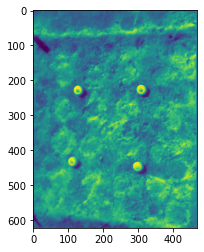

In [6]:

Array_img=[]
#Applying equalization techniques on the images & saving the results.
for i in range(nz):
  image_name='image'+str(i+1)
  #print(image_name)
  array_image=img[:,:,i]
  #print(type(array_image)) 
  file_name=f"Downloads/Lmines/images/{image_name}.jpg"
  plt.imshow(img[:,:,1].T)
   
  cv2.imwrite(file_name, array_image.T)
  Array_img.append(array_image.T)
  

<class 'numpy.ndarray'>
(622, 468)


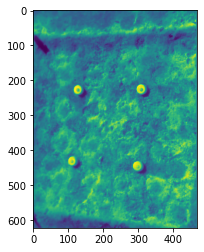

In [7]:



path_image='Downloads/Lmines/images/image1.jpg'
# load the image and convert into
# numpy array
image = PIL.Image.open(path_image)
plt.imshow(image)  
# asarray() class is used to convert
# PIL images into NumPy arrays
np_imagetest = np.array(image)
  
# <class 'numpy.ndarray'>
print(type(np_imagetest))
W,H= (np_imagetest).shape 
#  shape
print((np_imagetest).shape)



In [8]:
#Ground-truth data for Landmine Thermal Imaging Series| IEEE Dataport 
mine_b =np.array([[90 ,192],[83 ,292],[87 ,385],[76 ,491],[177 ,190],[179, 279],[167, 395] ,[164, 498],
                 [270, 190],[270, 296],[270, 400],[256, 510],[373, 200],[362, 300],[360, 415],[350, 511]])
mine_s =np.array([[126, 242],[110, 446],[306, 241],[297, 460]])

In [9]:
mines=np.concatenate((mine_b,mine_s),axis=0)
cols=["x1","y1"]
#mines_df=pd.read_excel("Desktop/annotation.xlsx")
mines_df=pd.DataFrame(data=mines,columns=cols)
#print(mines_df)
print(len(mines_df))
listdf=mines_df[['x1','y1']].values.tolist()
#print(mines_df)

20


In [12]:
def create_mask(path_img,list_df):
      
    path_img=path_img

     # extract image id
    image_id = path_img.split('/')[-4:]
    path_mask=image_id[0]+'/'+image_id[1]+'/masks/'+image_id[3]
    
    img = PIL.Image.open(path_img)
  
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    np_image = np.array(img)

    # <class 'numpy.ndarray'>
    
    W,H= (np_image).shape 
    x = np.zeros(np_image.shape,dtype=float)
    fig = plt.figure(frameon=False)
  
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # Display the image
    ax.imshow(x)
    for i in range(20): 
        [x1,y1]=list_df[i]
        bbox_list=[x1,y1]
        bbox=bbox_list
        #print(bbox)
        rect = patches.Rectangle((bbox[0], bbox[1]), 55,55, linewidth=1,
                         edgecolor='r', facecolor="g")
 
        ax.add_patch(rect)
        #plt.axis('off')
    
        #ax.imshow(x)
    # Create figure and axes
    
    buff=io.BytesIO()
    fig.savefig(buff, format='jpg', dpi='figure')
    buff.seek(0)
    
    img_mask = np.frombuffer(buff.getvalue(), dtype= 'uint8',count= -1, offset=0)
    
    fig.savefig(path_mask, bbox_inches='tight', pad_inches=0)   
    buff.close()
    plt.close(fig) 
    

In [ ]:
#ETL(Extract-Tranform-Load) pipeline

In [119]:
images_dataset_dir = 'Downloads/Lmines/images/' 
masks_dataset_dir = 'Downloads/Lmines/masks/' 
images_ds=list(sorted(os.listdir(images_dataset_dir)))
masks_ds=list(sorted(os.listdir(masks_dataset_dir)))
print(len(masks_ds))
print(len(images_ds))


118
118


In [152]:

list_imgPath=[images_dataset_dir + image for image in images_ds]
del list_imgPath[0]
#print((list_imgPath))

In [ ]:
for path_img in list_imgPath:
    create_mask(path_img,listdf)

In [153]:
list_maskPath=[masks_dataset_dir + mask for mask in images_ds]
del list_maskPath[0]
#print((list_maskPath))

In [122]:
num_examples=len(list_imgPath)
print(len(list_maskPath))
print(num_examples)

117
117


In [123]:
#Create dataset in Tensorflow
dataset_tf = tf.data.Dataset.from_tensor_slices((list_imgPath[0:118],list_maskPath[0:118]))

In [124]:
#Function to partition dataset into Training,Validation & Test sets
def get_dataset_partitions_tf(ds, ds_size, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds,train_size,val_size,test_size

In [125]:
train_ds, val_ds, test_ds,train_size,val_size,test_size = get_dataset_partitions_tf(dataset_tf,num_examples)
print(val_ds.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [126]:
#Defining
print("num_examples:",num_examples)
train_ratio=train_size/num_examples
test_ratio=test_size/num_examples
val_ratio=val_size/num_examples
print("test-train-val-split:")
print("train_size:",train_size, "test_size:",test_size,"val_size:",val_size )
train_length=train_size
test_length=test_size
val_length=val_size
print(f"train_ratio:{train_ratio:.2f}")
print(f"test_ratio:{test_ratio:.2f}")
print(f"val_ratio:{val_ratio:.2f}")
batch_size = 6
buffer_size = 8
STEPS_PER_EPOCH = int(train_size // batch_size)
print("Steps per Epoch",STEPS_PER_EPOCH)
EPOCHS = 10

VALIDATION_STEPS = val_size//batch_size
print("Validation Steps:",VALIDATION_STEPS)
VAL_SUBSPLITS = 1

num_examples: 117
test-train-val-split:
train_size: 93 test_size: 11 val_size: 11
train_ratio:0.79
test_ratio:0.09
val_ratio:0.09
Steps per Epoch 15
Validation Steps: 1


In [127]:
def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    img = tf.image.resize(img/255, size= (128 ,128))
    
    return img 

In [128]:

def load_img_mask(x,y):
    img = process_img(x)
    mask = process_img(y)
    mask = (mask-tf.math.reduce_mean(mask))/tf.math.reduce_std(mask)
    mask = tf.abs(mask)
    #mask = tf.where(mask<0.5,0,1)
    return img,mask

In [129]:
train_dataset = train_ds.map(load_img_mask)


In [130]:
train_dataset = train_dataset.shuffle(buffer_size = buffer_size)
train_dataset = train_dataset.batch(batch_size = batch_size) 

(128, 128, 3)
(128, 128)
(128, 128, 3)
(128, 128)
(128, 128, 3)
(128, 128)
(128, 128, 3)
(128, 128)


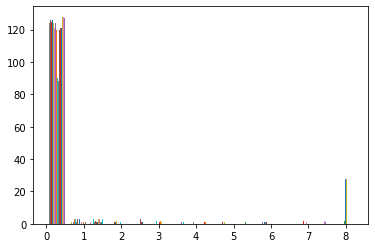

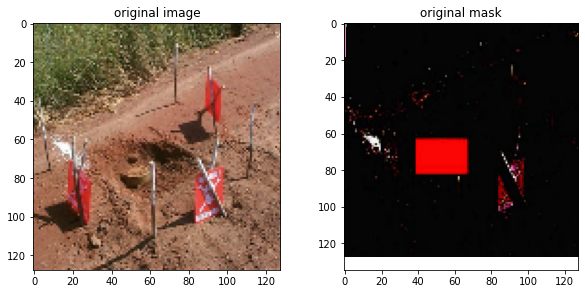

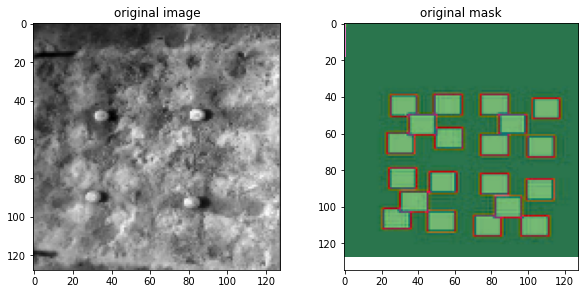

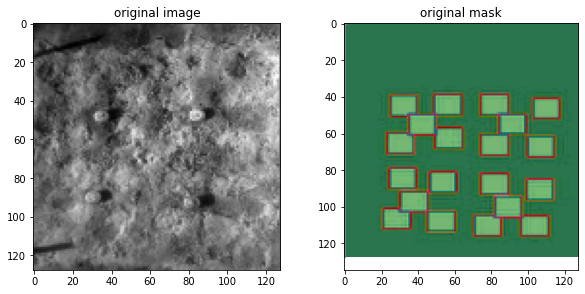

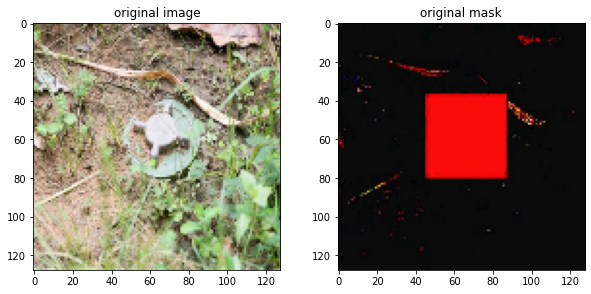

In [154]:
#Visualizing the Dataset images & prepared masks
for img,mask in train_dataset.take(4):
        print(mask[0].shape) 
        m = mask[0]
        print(m[:,:,0].shape)
        #print(m)
        plt.hist(m[:,:,0],bins=15)
        fig = plt.figure(figsize =(10,10))
        fig.tight_layout()
        fig.add_subplot(2,2,1).set_title('original image')
        #print(img[0])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
        
        fig.add_subplot(2,2,2).set_title('original mask')
           #display_mask 
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
        
     

In [132]:

val_dataset = val_ds.map(load_img_mask).batch(batch_size=batch_size)

test_dataset = test_ds.map(load_img_mask).batch(batch_size=batch_size)

In [133]:

"""
Image segmentation with a U-Net architecture Using Keras Functional API
"""

'\nImage segmentation with a U-Net architecture Using Keras Functional API\n'

In [134]:
#Code credit Margaret Maynard-Reid
#https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
#U-Net Image Segmentation in Keras

In [135]:
def double_conv_block(x,n_filters):
    
    #Conv2D then ReLU activation
    #kernel_initializer="he_normal"
    x = layers.Conv2D(n_filters,3,padding="same",activation='relu',kernel_initializer="he_normal")(x)
    #Conv2D then ReLU activation
    #kernel_initializer="he_normal"
    x = layers.Conv2D(n_filters,3,padding="same",activation='relu',kernel_initializer="he_normal")(x)
    
    return x

In [136]:
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
#https://keras.io/api/layers/regularization_layers/dropout/



In [137]:
def downsample_block(x,n_filters):
    
    f = double_conv_block(x,n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.1)(p)
    
    return f,p

In [138]:
def upsample_block(x,conv_features,n_filters):
    #upsample https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
    x = layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
    #Concatenate
    x = layers.concatenate([x,conv_features])
    #dropout
    #x = layers.Dropout(0.3)(x)
    #Conv2D twice with ReLU activation
    x = double_conv_block(x,n_filters)
    
    return x

In [139]:
#Build the U-Net Model

def unet_model_arch():
        
        #inputs
        inputs = layers.Input(shape=(128,128,3))

        #encoder :Compacting - Downsample
        #1- downsample
        f1, p1 = downsample_block(inputs,64)
        #2- downsample
        f2 ,p2 = downsample_block(p1,128)
        #3- downsample
        f3, p3 = downsample_block(p2,256)
        #4- downsample
        f4 ,p4 = downsample_block(p3,512)

        #Transition
        features = double_conv_block(p4,1024)

        #decoder: expanding-upsample

        #6-upsample
        us6 = upsample_block(features,f4,512)

        #7-upsample
        us7 = upsample_block(us6,f3,256)

        #8-upsample
        us8 = upsample_block(us7,f2,128)

        #9-upsample
        us9 = upsample_block(us8,f1,64)

        #outputs
        outputs = layers.Conv2D(3,1,padding="same",activation="softmax")(us9)

        #U-Net Model with Keras Functional API
        unet_model = tf.keras.Model(inputs,outputs,name="U-Net")
        
        return unet_model

In [140]:
unet_model = unet_model_arch()

In [141]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_57[0][0]']              
                                )                                                             

                                                                                                  
 conv2d_73 (Conv2D)             (None, 128, 128, 64  73792       ['concatenate_15[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_73[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 128, 128, 3)  195         ['conv2d_74[0][0]']              
                                                                                                  
Total params: 34,513,475
Trainable params: 34,513,475
Non-trainable params: 0
_______________________________

In [157]:


unet_model.compile(optimizer='sgd',loss = 'mse',metrics=['accuracy'])
#unet_model.compile(optimizer='sgd',loss='mse',metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

callbacks =[tf.keras.callbacks.ModelCheckpoint("landmine_area_segment.h5",save_best_only= True)]
#optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)

In [ ]:
train_preds = unet_model.predict(train_dataset)

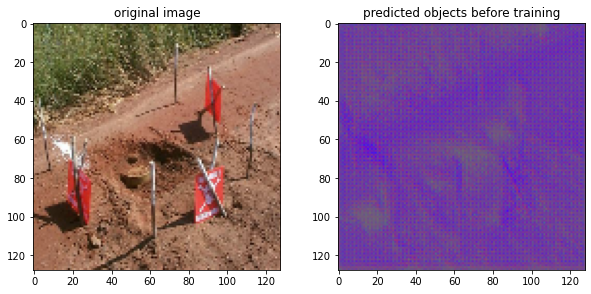

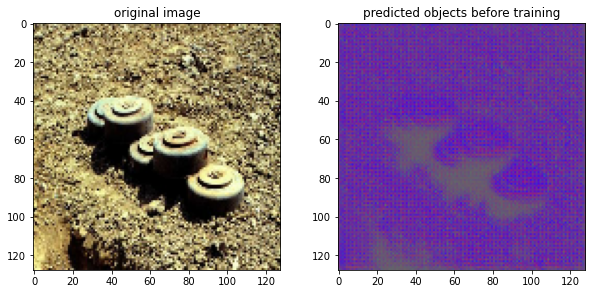

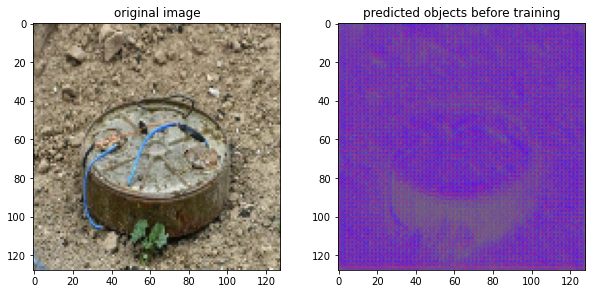

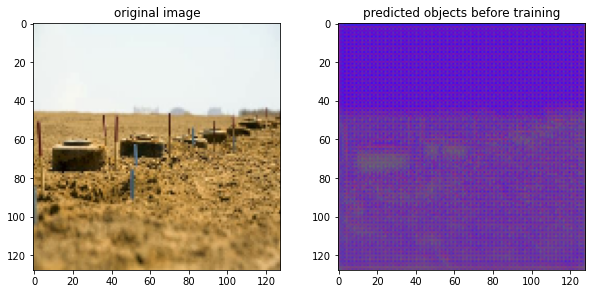

In [143]:
#Sanity Check Visualizing the U-Net Model output prediction before training
for image, mask in train_dataset.take(4):
        pred_mask = unet_model.predict(image)
        fig = plt.figure(figsize =(10,10))
        fig.tight_layout()
        fig.add_subplot(2,2,1).set_title('original image')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
        fig.add_subplot(2,2,2).set_title('predicted objects before training')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
            

In [158]:
#Training the UNet Model on VisDrone2019 train data
model_history=unet_model.fit(train_dataset,
                epochs= EPOCHS,
                validation_data=val_dataset,callbacks=callbacks)

Epoch 1/10
16/16 [==============================] - 26s 2s/step - loss: 0.5232 - accuracy: 0.7683 - val_loss: 0.4457 - val_accuracy: 0.9319
Epoch 2/10
16/16 [==============================] - 27s 2s/step - loss: 0.5234 - accuracy: 0.7688 - val_loss: 0.4455 - val_accuracy: 0.9319
Epoch 3/10
16/16 [==============================] - 28s 2s/step - loss: 0.5233 - accuracy: 0.7689 - val_loss: 0.4429 - val_accuracy: 0.9321
Epoch 4/10
16/16 [==============================] - 30s 2s/step - loss: 0.5232 - accuracy: 0.7691 - val_loss: 0.4449 - val_accuracy: 0.9322
Epoch 5/10
16/16 [==============================] - 35s 2s/step - loss: 0.5227 - accuracy: 0.7693 - val_loss: 0.4433 - val_accuracy: 0.9320
Epoch 6/10
16/16 [==============================] - 42s 3s/step - loss: 0.5222 - accuracy: 0.7693 - val_loss: 0.4462 - val_accuracy: 0.9321
Epoch 7/10
16/16 [==============================] - 49s 3s/step - loss: 0.5220 - accuracy: 0.7699 - val_loss: 0.4430 - val_accuracy: 0.9321
Epoch 8/10
16/16 [==

In [ ]:
test_preds = unet_model.predict(test_dataset)


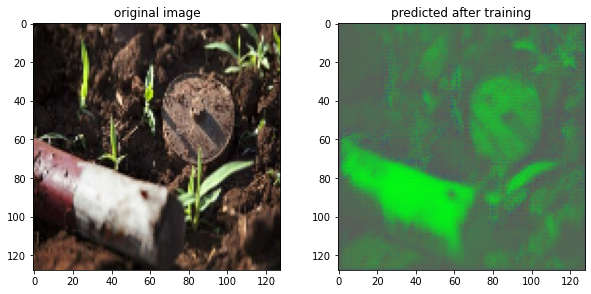

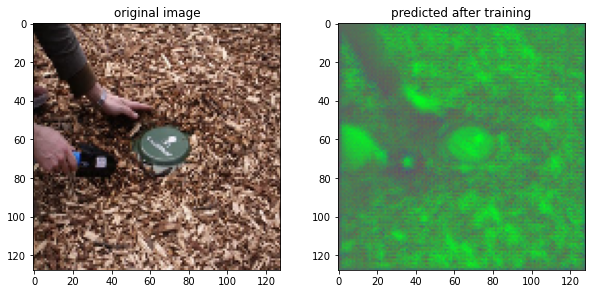

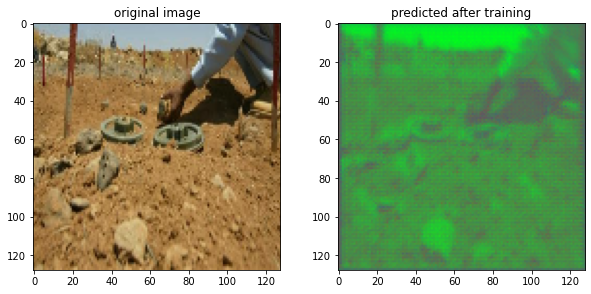

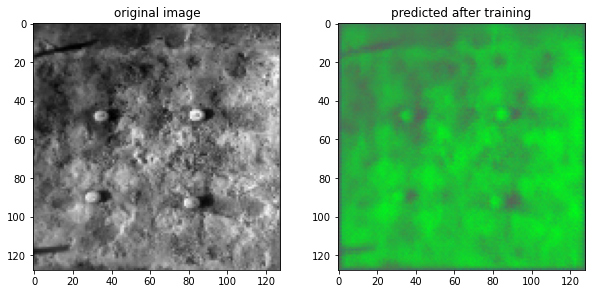

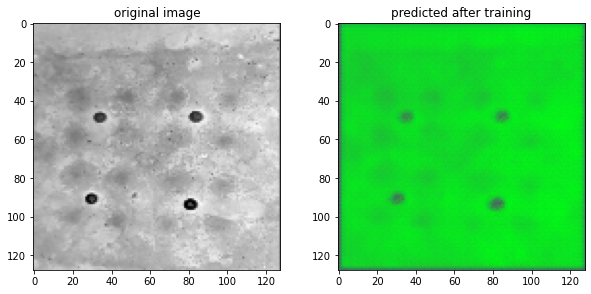

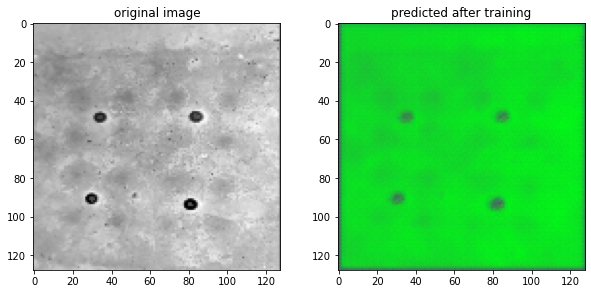

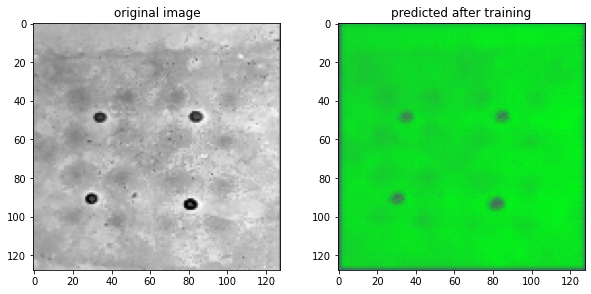

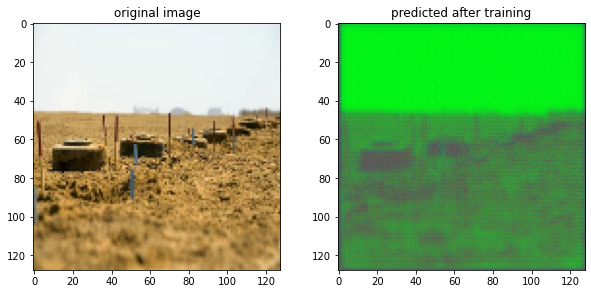

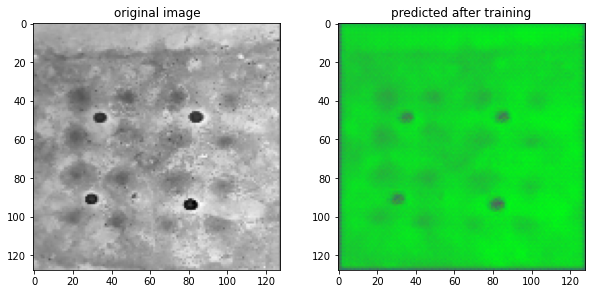

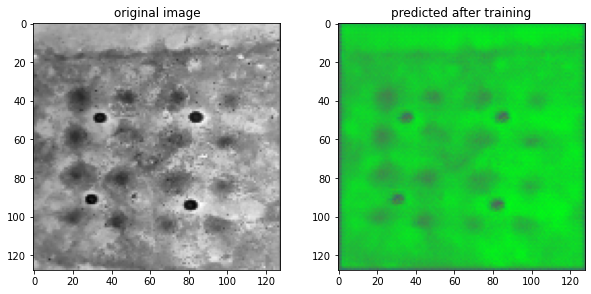

In [159]:
#Visualising the trained UNet Model Prediction on VisDrone2019 test data 

#Objects predicted in test set after training 
for image, mask in train_dataset.take(10):
        pred_mask = unet_model.predict(image)
        fig = plt.figure(figsize =(10,10))
        fig.tight_layout()
        fig.add_subplot(2,2,1).set_title('original image')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
        fig.add_subplot(2,2,2).set_title('predicted after training')
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
            

In [160]:
print(model_history.history.keys())
print(model_history.epoch)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


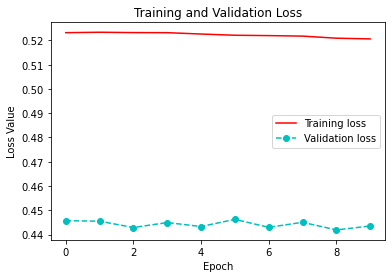

In [161]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epoch_num = model_history.epoch

plt.plot(epoch_num, loss, 'r', label='Training loss')
plt.plot(epoch_num, val_loss, 'co--', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss')
plt.legend()

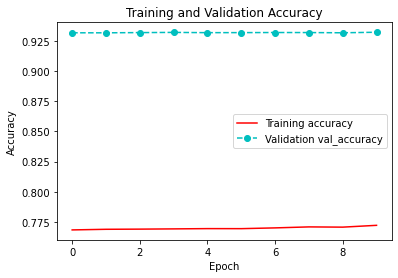

In [162]:
plt.plot(epoch_num, accuracy, 'r', label='Training accuracy')
plt.plot(epoch_num, val_accuracy, 'co--', label='Validation val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [163]:
test_dataset.enumerate

<bound method DatasetV2.enumerate of <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>>

In [164]:
results = unet_model.evaluate(test_dataset)

3/3 [==============================] - 2s 570ms/step - loss: 0.5227 - accuracy: 0.7301
